## 3.1 Classification and regression with a two-layer perceptron
### 3.1.1 Classification of linearly non-separable data


=== Hidden-unit sweep (best of runs) ===
epochs=2500, eta=0.05, runs_per_H=1
H | final_miscls | final_MSE | best_seed
--+-------------+----------+----------
 1 |          36 |   0.4794 | 2
 2 |          36 |   0.4817 | 2
 3 |          36 |   0.4795 | 2
 5 |          37 |   0.4771 | 2
 8 |          37 |   0.4738 | 2
10 |           2 |   0.1490 | 2
15 |          37 |   0.4723 | 2
20 |           0 |   0.0899 | 2


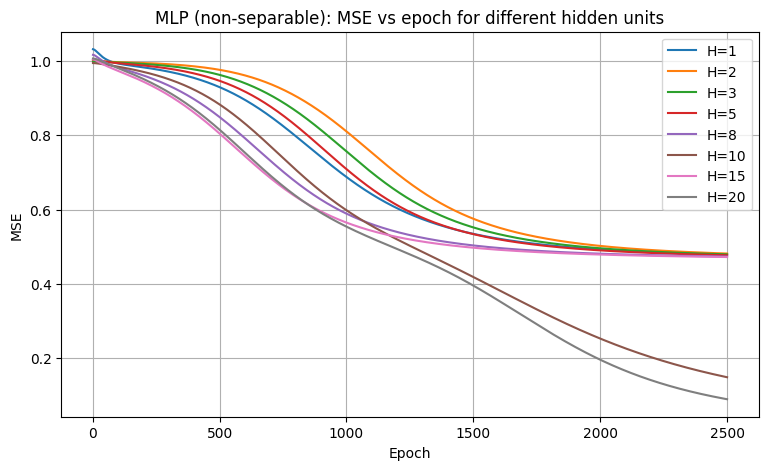

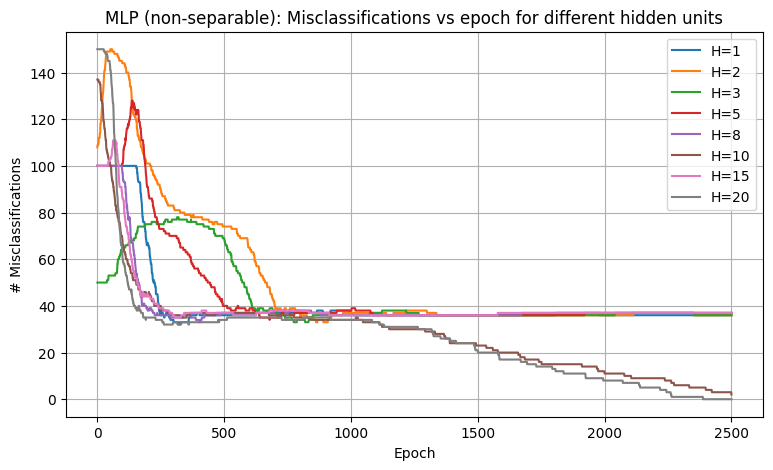

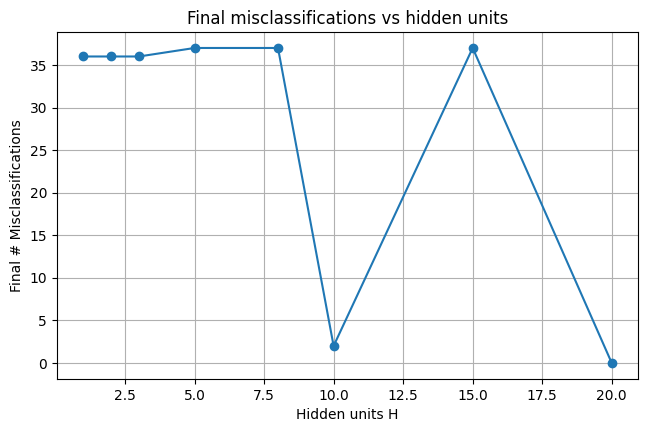

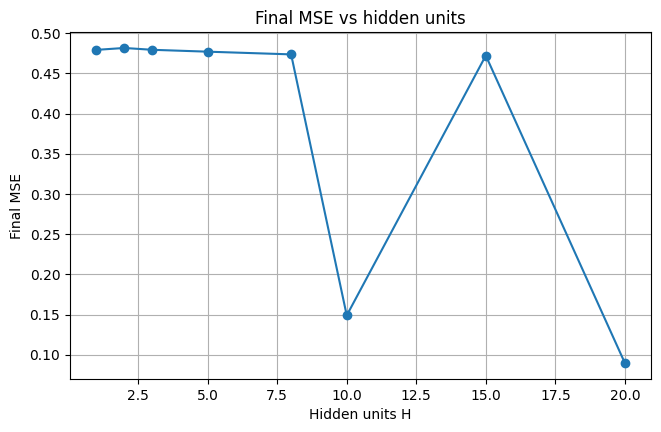

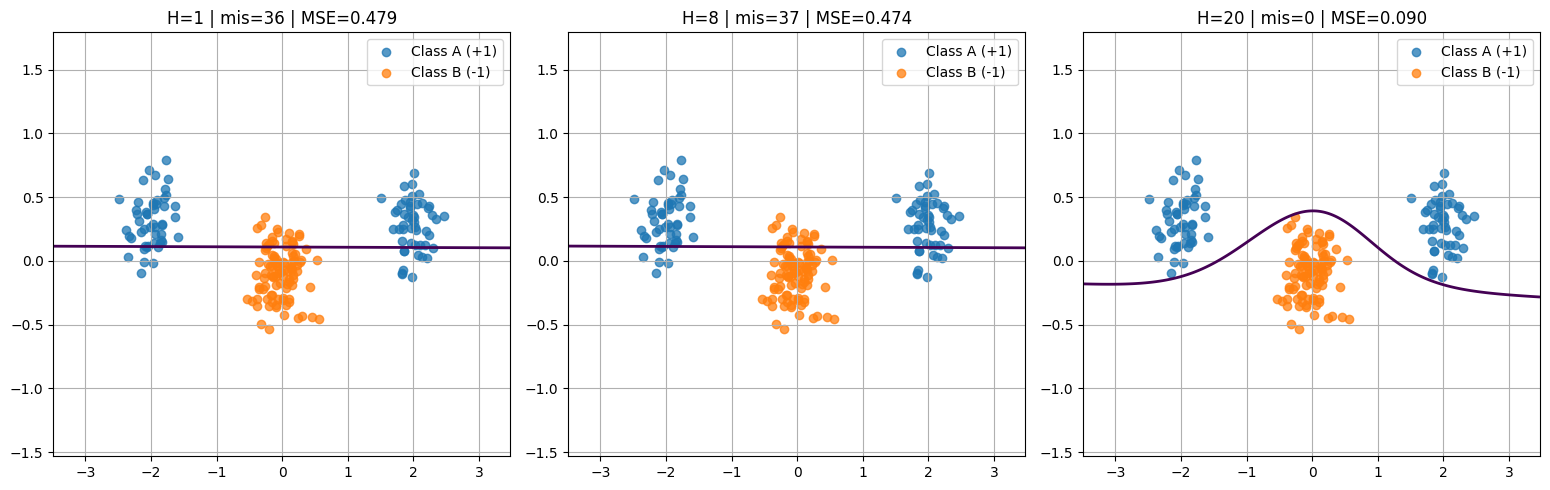


=== Best model metrics on FULL set ===
H= 1  acc=0.820  sens=0.830  spec=0.810  (TP=83, TN=81, FP=19, FN=17)
H= 2  acc=0.820  sens=0.830  spec=0.810  (TP=83, TN=81, FP=19, FN=17)
H= 3  acc=0.820  sens=0.830  spec=0.810  (TP=83, TN=81, FP=19, FN=17)
H= 5  acc=0.815  sens=0.820  spec=0.810  (TP=82, TN=81, FP=19, FN=18)
H= 8  acc=0.815  sens=0.820  spec=0.810  (TP=82, TN=81, FP=19, FN=18)
H=10  acc=0.990  sens=0.990  spec=0.990  (TP=99, TN=99, FP=1, FN=1)
H=15  acc=0.815  sens=0.820  spec=0.810  (TP=82, TN=81, FP=19, FN=18)
H=20  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Helpers (from your base code)
# ============================================================
def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (d+1, N)

def predict_bipolar_from_scores(s):
    return np.where(s >= 0, 1.0, -1.0)

def confusion_stats(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == -1) & (y_pred == -1))
    FP = np.sum((y_true == -1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == -1))
    acc = (TP + TN) / max(1, (TP + TN + FP + FN))
    sens = TP / max(1, (TP + FN))
    spec = TN / max(1, (TN + FP))
    return {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "acc": acc, "sens": sens, "spec": spec}

def fixed_axis_limits(X, pad=0.5):
    xmin, xmax = X[0].min() - pad, X[0].max() + pad
    ymin, ymax = X[1].min() - pad, X[1].max() + pad
    return xmin, xmax, ymin, ymax

# ============================================================
# DATA: MATLAB-like non-separable dataset (your function)
# ============================================================
def make_special_nonseparable_dataset(ndata=100, mA=(1.0, 0.3), sigmaA=0.2,
                                     mB=(0.0, -0.1), sigmaB=0.2, seed=0):
    rng = np.random.default_rng(seed)
    mA = np.array(mA, dtype=float)
    mB = np.array(mB, dtype=float)

    n1 = int(round(0.5 * ndata))
    n2 = ndata - n1

    A1_left  = rng.standard_normal(n1) * sigmaA - mA[0]
    A1_right = rng.standard_normal(n2) * sigmaA + mA[0]
    A1 = np.concatenate([A1_left, A1_right])
    A2 = rng.standard_normal(ndata) * sigmaA + mA[1]

    B1 = rng.standard_normal(ndata) * sigmaB + mB[0]
    B2 = rng.standard_normal(ndata) * sigmaB + mB[1]

    classA = np.vstack([A1, A2])  # (2,ndata)
    classB = np.vstack([B1, B2])  # (2,ndata)

    X = np.hstack([classA, classB])                  # (2,2*ndata)
    y = np.hstack([np.ones(ndata), -np.ones(ndata)]) # (2*ndata,)

    perm = rng.permutation(2 * ndata)
    return X[:, perm], y[perm], classA, classB

# ============================================================
# Bipolar sigmoid + derivative (computed from output)
# phi(x) = 2/(1+e^-x) - 1   in [-1,1]
# phi'(x) = 0.5*(1+phi)*(1-phi)
# ============================================================
def bipolar_sigmoid(z):
    # stable-ish for typical lab ranges
    return 2.0 / (1.0 + np.exp(-z)) - 1.0

def bipolar_sigmoid_prime_from_output(y):
    return 0.5 * (1.0 + y) * (1.0 - y)

# ============================================================
# Two-layer MLP (1 hidden layer), batch backprop
# Input: X (2,N) , targets t in {-1,+1} shape (N,)
# Params:
#   W: (H,3)    maps [x1,x2,1] -> hidden preact
#   V: (1,H+1)  maps [h;1] -> output preact
# ============================================================
def mlp_forward(X, W, V):
    Xb = add_bias_row(X)            # (3,N)
    zh = W @ Xb                     # (H,N)
    h  = bipolar_sigmoid(zh)        # (H,N)
    hb = add_bias_row(h)            # (H+1,N)
    zo = V @ hb                     # (1,N)
    o  = bipolar_sigmoid(zo)        # (1,N)
    return Xb, h, hb, o

def mlp_mse(o, t):
    # o: (1,N), t: (N,)
    return float(np.mean((t - o.ravel())**2))

def mlp_predict(W, V, X):
    _, _, _, o = mlp_forward(X, W, V)
    yhat = predict_bipolar_from_scores(o.ravel())  # threshold at 0
    return yhat, o.ravel()

def train_mlp_batch(X, t, H=5, eta=0.01, alpha=0.9, epochs=500, seed=0, init_std=0.1):
    rng = np.random.default_rng(seed)
    N = X.shape[1]

    W = rng.normal(0.0, init_std, size=(H, 3))
    V = rng.normal(0.0, init_std, size=(1, H + 1))

    dW_prev = np.zeros_like(W)
    dV_prev = np.zeros_like(V)

    mse_curve, mis_curve = [], []

    for ep in range(epochs):
        Xb, h, hb, o = mlp_forward(X, W, V)

        do = (o.ravel() - t) * bipolar_sigmoid_prime_from_output(o.ravel())
        do = do.reshape(1, N)

        V_no_bias = V[:, :-1]
        dh = (V_no_bias.T @ do) * bipolar_sigmoid_prime_from_output(h)

        gradV = (do @ hb.T) / N
        gradW = (dh @ Xb.T) / N

        # Momentum update (lab style)
        dV = alpha * dV_prev - (1.0 - alpha) * gradV
        dW = alpha * dW_prev - (1.0 - alpha) * gradW
        V += eta * dV
        W += eta * dW
        dV_prev, dW_prev = dV, dW

        mse_curve.append(mlp_mse(o, t))
        yhat = predict_bipolar_from_scores(o.ravel())
        mis_curve.append(int(np.sum(yhat != t)))

    return W, V, np.array(mse_curve), np.array(mis_curve)

# ============================================================
# Plot decision boundary for MLP via contour o(x)=0
# ============================================================
def plot_mlp_boundary(ax, X, y, W, V, title="", grid_n=250):
    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], alpha=0.75, label="Class A (+1)")
    ax.scatter(B[0], B[1], alpha=0.75, label="Class B (-1)")

    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    xs = np.linspace(xmin, xmax, grid_n)
    ys = np.linspace(ymin, ymax, grid_n)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()])  # (2,grid_n^2)

    _, scores = mlp_predict(W, V, grid)         # scores in [-1,1]
    ZZ = scores.reshape(grid_n, grid_n)

    ax.contour(XX, YY, ZZ, levels=[0.0], linewidths=2)
    ax.set_title(title)
    ax.legend()

# ============================================================
# Experiment: vary hidden units, track MSE + miscls, show plots
# ============================================================
def partI_nonseparable_hidden_sweep(seed=2):
    # dataset from your Part 2 generator (the non-separable one)
    X, y, _, _ = make_special_nonseparable_dataset(
        ndata=100, mA=(2.0, 0.3), sigmaA=0.2,
        mB=(0.0, -0.1), sigmaB=0.2,
        seed=seed
    )

    # sweep settings
    H_list = [1, 2, 3, 5, 8, 10, 15, 20]
    epochs = 2500
    eta = 0.05
    runs_per_H = 1

    summary = []  # (H, best_mis, best_mse, best_run_seed)

    # ---- overlay learning curves (pick best run per H) ----
    best_curves = {}

    for H in H_list:
        best = {"mis": 10**9, "mse": np.inf, "W": None, "V": None, "mse_curve": None, "mis_curve": None, "run_seed": None}

        for r in range(runs_per_H):
            run_seed = seed 
            W, V, mse_curve, mis_curve = train_mlp_batch(
                X, y, H=H, eta=eta, epochs=epochs, seed=run_seed, init_std=0.2
            )

            final_mis = int(mis_curve[-1])
            final_mse = float(mse_curve[-1])

            # choose "best" primarily by miscls, tie-break by mse
            if (final_mis < best["mis"]) or (final_mis == best["mis"] and final_mse < best["mse"]):
                best.update({"mis": final_mis, "mse": final_mse, "W": W, "V": V,
                             "mse_curve": mse_curve, "mis_curve": mis_curve, "run_seed": run_seed})

        best_curves[H] = best
        summary.append((H, best["mis"], best["mse"], best["run_seed"]))

    # ---- print summary table ----
    print("\n=== Hidden-unit sweep (best of runs) ===")
    print(f"epochs={epochs}, eta={eta}, runs_per_H={runs_per_H}")
    print("H | final_miscls | final_MSE | best_seed")
    print("--+-------------+----------+----------")
    for H, mis, mse_val, s in summary:
        print(f"{H:2d} | {mis:11d} | {mse_val:8.4f} | {s}")

    # ---- plot MSE curves (best run for each H) ----
    xs = np.arange(1, epochs + 1)
    plt.figure(figsize=(9, 5))
    for H in H_list:
        plt.plot(xs, best_curves[H]["mse_curve"], label=f"H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MLP (non-separable): MSE vs epoch for different hidden units")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- plot misclassification curves (best run for each H) ----
    plt.figure(figsize=(9, 5))
    for H in H_list:
        plt.plot(xs, best_curves[H]["mis_curve"], label=f"H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("# Misclassifications")
    plt.title("MLP (non-separable): Misclassifications vs epoch for different hidden units")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- plot final metrics vs H ----
    Hs = np.array([s[0] for s in summary])
    mis_final = np.array([s[1] for s in summary])
    mse_final = np.array([s[2] for s in summary])

    plt.figure(figsize=(7.5, 4.5))
    plt.plot(Hs, mis_final, marker="o")
    plt.xlabel("Hidden units H")
    plt.ylabel("Final # Misclassifications")
    plt.title("Final misclassifications vs hidden units")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7.5, 4.5))
    plt.plot(Hs, mse_final, marker="o")
    plt.xlabel("Hidden units H")
    plt.ylabel("Final MSE")
    plt.title("Final MSE vs hidden units")
    plt.grid(True)
    plt.show()

    # ---- show decision boundaries for a few H values (underfit / better / big) ----
    show_H = [H_list[0], H_list[len(H_list)//2], H_list[-1]]
    fig, axes = plt.subplots(1, len(show_H), figsize=(5.2*len(show_H), 5))
    if len(show_H) == 1:
        axes = [axes]
    for ax, H in zip(axes, show_H):
        W = best_curves[H]["W"]
        V = best_curves[H]["V"]
        title = f"H={H} | mis={best_curves[H]['mis']} | MSE={best_curves[H]['mse']:.3f}"
        plot_mlp_boundary(ax, X, y, W, V, title=title, grid_n=250)
    plt.tight_layout()
    plt.show()

    # ---- extra: print acc/sens/spec for best models ----
    print("\n=== Best model metrics on FULL set ===")
    for H in H_list:
        W = best_curves[H]["W"]
        V = best_curves[H]["V"]
        yhat, _ = mlp_predict(W, V, X)
        st = confusion_stats(y, yhat)
        print(f"H={H:2d}  acc={st['acc']:.3f}  sens={st['sens']:.3f}  spec={st['spec']:.3f}  "
              f"(TP={st['TP']}, TN={st['TN']}, FP={st['FP']}, FN={st['FN']})")

# ============================================================
# Run
# ============================================================
if __name__ == "__main__":
    partI_nonseparable_hidden_sweep(seed=2)



=== Scenario: Random 25% from each class ===
Train N=150, Val N=50
Final Train: mis=0  mse=0.0782
Final Val:   mis=0  mse=0.0647


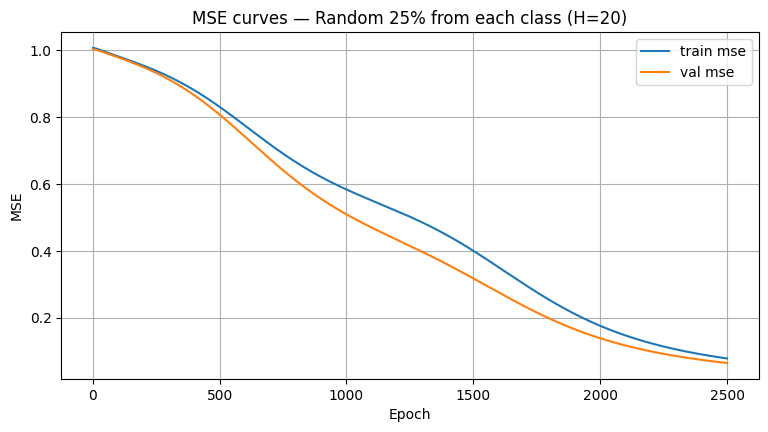

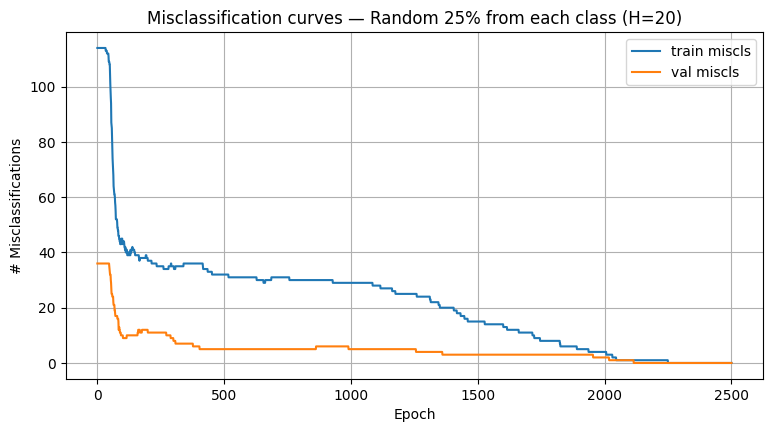

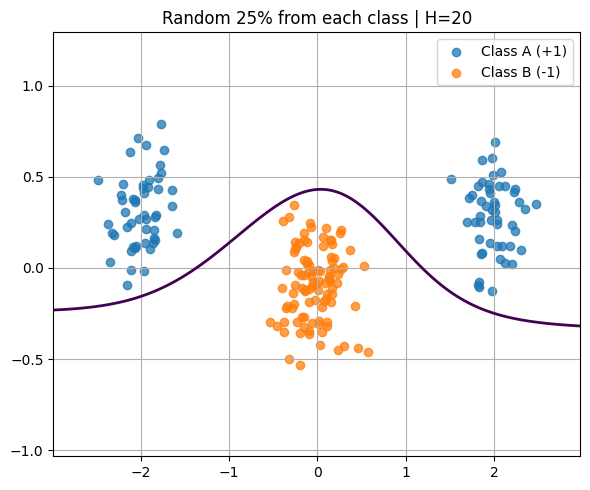


=== Scenario: Random 50% from classA ===
Train N=150, Val N=50
Final Train: mis=0  mse=0.0778
Final Val:   mis=0  mse=0.0935


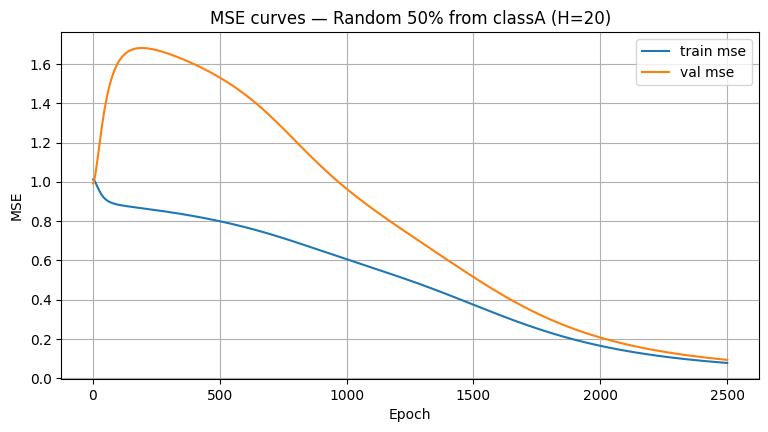

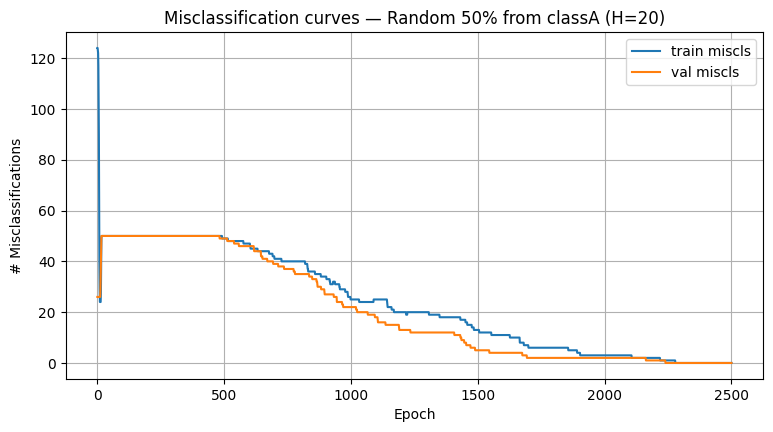

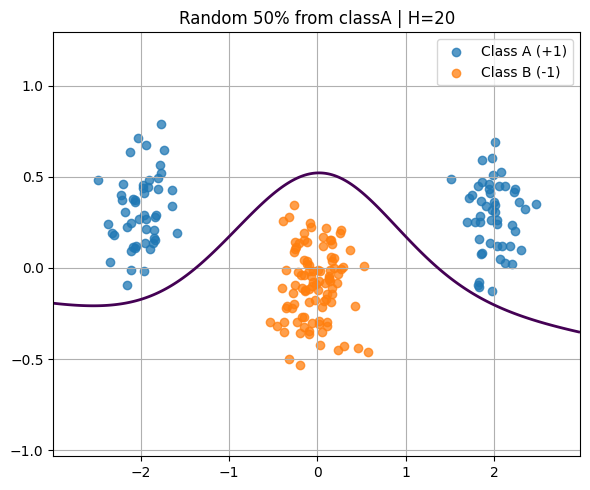


=== Scenario: 20% of A (x<0) + 80% of A (x>0) ===
Train N=150, Val N=50
Final Train: mis=10  mse=0.2713
Final Val:   mis=40  mse=3.1999


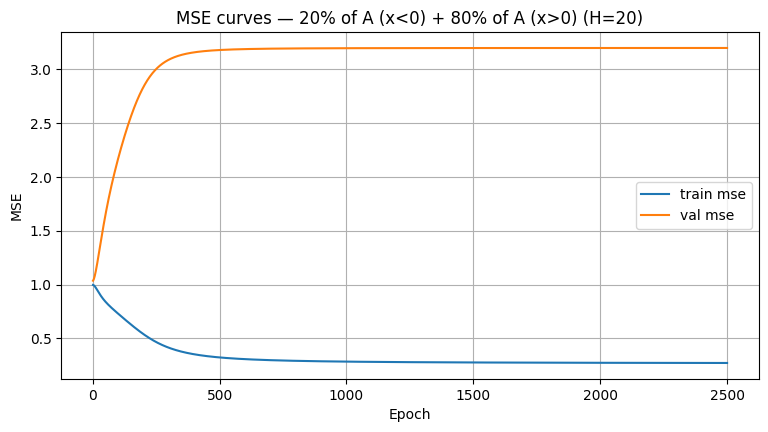

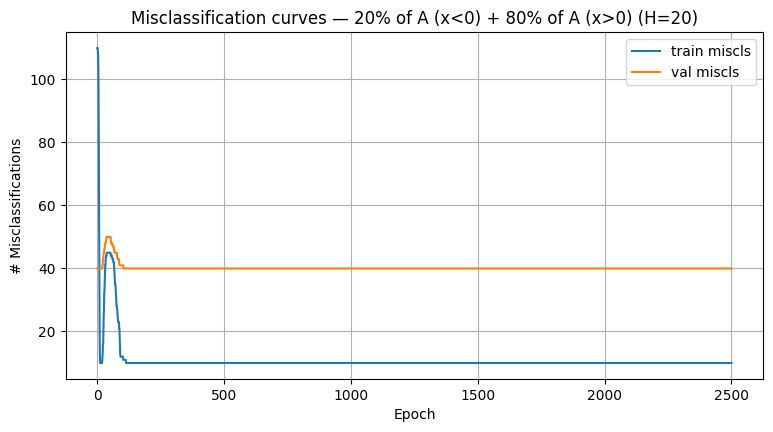

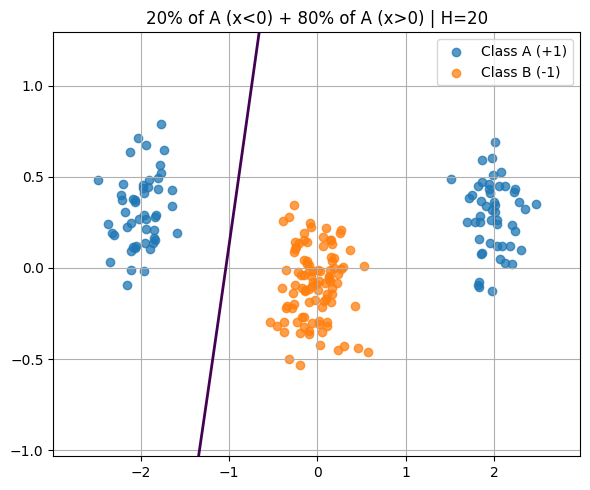

In [ ]:
def build_class_masks(X, y):
    isA = (y == 1)
    isB = (y == -1)
    A_x_lt0 = isA & (X[0, :] < 0)
    A_x_gt0 = isA & (X[0, :] > 0)
    return isA, isB, A_x_lt0, A_x_gt0


def split_train_val_scenario(X, y, scenario, seed=0):
    rng = np.random.default_rng(seed)
    N = X.shape[1]
    idx_all = np.arange(N)

    isA, isB, A_x_lt0, A_x_gt0 = build_class_masks(X, y)
    idx_A = idx_all[isA]
    idx_B = idx_all[isB]

    if scenario == "25_each":
        nA = int(round(0.25 * len(idx_A)))
        nB = int(round(0.25 * len(idx_B)))

        idx_val = np.concatenate([
            rng.choice(idx_A, nA, replace=False),
            rng.choice(idx_B, nB, replace=False)
        ])

    elif scenario == "50_A":
        nA = int(round(0.50 * len(idx_A)))
        idx_val = rng.choice(idx_A, nA, replace=False)

    elif scenario == "A_20_80":
        idx_lt0 = idx_all[A_x_lt0]
        idx_gt0 = idx_all[A_x_gt0]

        n_lt0 = max(1, int(round(0.20 * len(idx_lt0))))
        n_gt0 = max(1, int(round(0.80 * len(idx_gt0))))

        idx_val = np.concatenate([
            rng.choice(idx_lt0, min(n_lt0, len(idx_lt0)), replace=False),
            rng.choice(idx_gt0, min(n_gt0, len(idx_gt0)), replace=False)
        ])

    else:
        raise ValueError("Unknown scenario")

    idx_val = np.unique(idx_val)
    idx_tr = np.setdiff1d(idx_all, idx_val)

    return X[:, idx_tr], y[idx_tr], X[:, idx_val], y[idx_val]


def train_mlp_batch_with_val(Xtr, ytr, Xva, yva, H=5, eta=0.01, alpha=0.9, epochs=500, seed=0, init_std=0.1):
    rng = np.random.default_rng(seed)
    Ntr = Xtr.shape[1]

    W = rng.normal(0.0, init_std, size=(H, 3))
    V = rng.normal(0.0, init_std, size=(1, H + 1))

    dW_prev = np.zeros_like(W)
    dV_prev = np.zeros_like(V)

    tr_mse, tr_mis, va_mse, va_mis = [], [], [], []

    for ep in range(epochs):
        # ---- train forward ----
        Xb, h, hb, o = mlp_forward(Xtr, W, V)

        do = (o.ravel() - ytr) * bipolar_sigmoid_prime_from_output(o.ravel())
        do = do.reshape(1, Ntr)

        dh = (V[:, :-1].T @ do) * bipolar_sigmoid_prime_from_output(h)

        gradV = (do @ hb.T) / Ntr
        gradW = (dh @ Xb.T) / Ntr

        # momentum update
        dV = alpha * dV_prev - (1.0 - alpha) * gradV
        dW = alpha * dW_prev - (1.0 - alpha) * gradW
        V += eta * dV
        W += eta * dW
        dV_prev, dW_prev = dV, dW

        # train metrics
        tr_mse.append(mlp_mse(o, ytr))
        tr_mis.append(int(np.sum(predict_bipolar_from_scores(o.ravel()) != ytr)))

        # val metrics
        _, _, _, o_va = mlp_forward(Xva, W, V)
        va_mse.append(mlp_mse(o_va, yva))
        va_mis.append(int(np.sum(predict_bipolar_from_scores(o_va.ravel()) != yva)))

    return W, V, np.array(tr_mse), np.array(tr_mis), np.array(va_mse), np.array(va_mis)

def run_validation_scenarios_on_same_data(X, y, seed_split=10, H=8, epochs=2000, eta=0.05, alpha=0.9):
    scenarios = [
        ("25_each", "Random 25% from each class"),
        ("50_A",    "Random 50% from classA"),
        ("A_20_80", "20% of A (x<0) + 80% of A (x>0)")
    ]

    for scen_key, scen_name in scenarios:
        Xtr, ytr, Xva, yva = split_train_val_scenario(X, y, scen_key, seed=seed_split)

        W, V, tr_mse, tr_mis, va_mse, va_mis = train_mlp_batch_with_val(
            Xtr, ytr, Xva, yva, H=H, eta=eta, alpha=alpha, epochs=epochs, seed=2, init_std=0.2
        )

        print(f"\n=== Scenario: {scen_name} ===")
        print(f"Train N={Xtr.shape[1]}, Val N={Xva.shape[1]}")
        print(f"Final Train: mis={tr_mis[-1]}  mse={tr_mse[-1]:.4f}")
        print(f"Final Val:   mis={va_mis[-1]}  mse={va_mse[-1]:.4f}")

        xs = np.arange(1, epochs+1)

        plt.figure(figsize=(9,4.5))
        plt.plot(xs, tr_mse, label="train mse")
        plt.plot(xs, va_mse, label="val mse")
        plt.title(f"MSE curves — {scen_name} (H={H})")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(9,4.5))
        plt.plot(xs, tr_mis, label="train miscls")
        plt.plot(xs, va_mis, label="val miscls")
        plt.title(f"Misclassification curves — {scen_name} (H={H})")
        plt.xlabel("Epoch")
        plt.ylabel("# Misclassifications")
        plt.grid(True)
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        plot_mlp_boundary(ax, X, y, W, V, title=f"{scen_name} | H={H}")
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Generate data ONCE
    X, y, classA, classB = make_special_nonseparable_dataset(
        ndata=100, mA=(2.0, 0.3), sigmaA=0.2,
        mB=(0.0, -0.1), sigmaB=0.2,
        seed=2
    )
    
     # Part I.2 (train/val scenarios) on SAME data
    run_validation_scenarios_on_same_data(X, y, seed_split=10, H=20, epochs=2500, eta=0.05, alpha=0.9)
    run_validation_scenarios_on_same_data(X, y, seed_split=10, H=10, epochs=2500, eta=0.05, alpha=0.9)
